In [54]:
import requests
import pandas as pd
import numpy as  np
import matplotlib.pyplot as plt
import warnings
%matplotlib inline
from datetime import timedelta, date, datetime
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse

#для выполнения запросов
from nile.api.v1 import (
    clusters,
    aggregators as na,
    extractors as ne,
    filters as nf,
    Record
)
cluster_yt = clusters.yt.Hahn(
    token = "your_token",
    pool = "cloud_analytics_pool",
)

def execute_query(query, cluster, alias, token, timeout=600):
    proxy = "http://{}.yt.yandex.net".format(cluster)
    s = requests.Session()
    url = "{proxy}/query?database={alias}&password={token}&enable_optimize_predicate_expression=0".\
    format(proxy=proxy, alias=alias, token=token)
    resp = s.post(url, data=query, timeout=timeout)
    resp.raise_for_status()
    rows = resp.text.strip().split('\n')
    return rows

def chyt_execute_query(query, cluster, alias, token, columns):
    i = 0
    while True:
        try:
            result = execute_query(query=query, cluster=cluster, alias=alias, token=token)
            users = pd.DataFrame([row.split('\t') for row in result], columns = columns)
            return users
        except Exception as err:
            print(err)
            print(query)
            break
            i += 1
            if i > 10:
                print('Break Excecution')
                break

cluster = "hahn"
alias = "*cloud_analytics"
token = "your_token"

In [233]:
#запросы для прогноза

def make_query(board_segment, start_date):
    b_segment = "'" + board_segment + "'"
    st_date = "'" + start_date + "'"
    new_date = "'" + '2019-01-01' + "'"
    retention = """
    SELECT
      week,
      arraySort((x, y)->y ,groupArray(retention), groupArray(cohort_week)) as ret
    FROM (
        SELECT 
            cohort_week,
            w as week,
            r/c as retention
        FROM (
            SELECT
              cohort_week,
              w,
              sum(r) as r 
            FROM (
                SELECT
                 cohort_week,
                 billing_account_id,
                 w,
                 r
                 FROM (
                    SELECT
                        toMonday(toDate(coalesce(first_ba_created_datetime, '2013-01-01'))) as cohort_week,
                        billing_account_id,
                        range(16) as w,
                        retention(
                               cohort_week = cohort_week,
                               assumeNotNull(toMonday(toDate(event_time)) = cohort_week),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 1)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 2)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 3)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 4)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 5)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 6)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 7)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 8)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 9)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 10)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 11)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 12)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 13)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 14))
                            ) as r
                    FROM "//home/cloud_analytics/cubes/acquisition_cube/cube"
                    WHERE 
                        first_ba_created_datetime is not null
                        and event = 'day_use'
                        and board_segment in ({0})
                        and sku_lazy != 1
                        
                    GROUP BY cohort_week, billing_account_id
                    HAVING 
                        toDate(cohort_week) >= toDate({1})
                    )
                ARRAY JOIN w,r
                WHERE w > 0
                )
            GROUP BY cohort_week, w
        ) as a
        LEFT JOIN (
            SELECT
                toMonday(toDate(first_ba_created_datetime)) as cohort_week,
                count(distinct billing_account_id) as c 
            FROM "//home/cloud_analytics/cubes/acquisition_cube/cube"
            WHERE 
                first_ba_created_datetime is not null
                and board_segment in ({0})
            GROUP BY cohort_week
            HAVING 
                toDate(cohort_week) >= toDate({1})
        ) as b
        ON a.cohort_week = b.cohort_week
        WHERE retention > 0
     )
     GROUP BY week
     """.format(b_segment, new_date)
    
    clients = """
        SELECT
            coalesce(clients, 0) as clients,
            week
        FROM (
            SELECT DISTINCT
                toMonday(toDate(event_time)) as week
            FROM "//home/cloud_analytics/cubes/acquisition_cube/cube"
            WHERE 
                toDate(week) >= toDate({1})
        ) as a
        LEFT JOIN (
            SELECT 
                uniqExact(billing_account_id) as clients,
                toMonday(toDate(first_ba_created_datetime)) as ba_created
            FROM "//home/cloud_analytics/cubes/acquisition_cube/cube"
            WHERE 
                first_ba_created_datetime is not NULL
                and board_segment = {0}
                and toDate(coalesce(first_ba_created_datetime, '2050-01-01')) <= toDate(event_time)
            GROUP BY ba_created
            HAVING 
                ba_created < toMonday(toDate(now())) 
        ) as b
        ON a.week = b.ba_created
        ORDER by week
    """.format(b_segment, st_date)
    
    avg = """
         SELECT
            week,
            arraySort((x, y)->y ,groupArray(weekly_avg), groupArray(cohort_week)) as weekly_avg
        FROM (
                SELECT 
                    cohort_week,
                    w as week,
                    weekly_cons / r as weekly_avg
                FROM (
                    SELECT
                        cohort_week,
                        w,
                        sum(cons_sum) as weekly_cons
                    FROM (    
                    SELECT
                        cohort_week,
                        w,
                        r,
                        billing_account_id,
                        cons_sum
                    FROM (
                        SELECT
                         cohort_week,
                         billing_account_id,
                         w,
                         r
                         FROM (
                            SELECT
                                toMonday(toDate(coalesce(first_ba_created_datetime, '2018-01-01'))) as cohort_week,
                                billing_account_id,
                                range(31) as w,
                                retention(
                                       cohort_week = cohort_week,
                                       assumeNotNull(toMonday(toDate(event_time)) = cohort_week),
                                       assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 1)),
                                       assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 2)),
                                       assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 3)),
                                       assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 4)),
                                       assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 5)),
                                       assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 6)),
                                       assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 7)),
                                       assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 8)),
                                       assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 9)),
                                       assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 10)),
                                       assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 11)),
                                       assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 12)),
                                       assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 13)),
                                       assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 14)),
                                       assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 15)),
                                       assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 16)),
                                       assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 17)),
                                       assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 18)),
                                       assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 19)),
                                       assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 20)),
                                       assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 21)),
                                       assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 22)),
                                       assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 23)),
                                       assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 24)),
                                       assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 25)),
                                       assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 26)),
                                       assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 27)),
                                       assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 28)),
                                       assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 29))
                                       ) as r
                            FROM "//home/cloud_analytics/cubes/acquisition_cube/cube"
                            WHERE 
                                first_ba_created_datetime is not null
                                and event = 'day_use'
                                and board_segment in ({0})
                                and sku_lazy != 1
                            GROUP BY cohort_week, billing_account_id
                            HAVING 
                               toDate(cohort_week) >= toDate({1})
                            )
                        ARRAY JOIN w,r
                    ) as a
                    LEFT JOIN (
                        SELECT 
                            sum(real_consumption) as cons_sum,
                            toMonday(toDate(coalesce(first_ba_created_datetime, '2018-01-01'))) as cohort_week,
                            billing_account_id,
                            toMonday(toDate(event_time)) as cons_week
                        FROM "//home/cloud_analytics/cubes/acquisition_cube/cube"
                        WHERE 
                            first_ba_created_datetime is not null
                            and event = 'day_use'
                            and board_segment in ({0})
                        GROUP BY billing_account_id, cohort_week, cons_week
                        HAVING 
                           toDate(cohort_week) >= toDate({1})
                    ) as b
                    ON  a.billing_account_id = b.billing_account_id
                        and addWeeks(a.cohort_week, a.w - 1) = b.cons_week
                    WHERE 
                        r > 0
                        and w > 0
                        and addWeeks(cohort_week, w) < toMonday(now())
                    )
                    GROUP BY cohort_week, w
                ) as a
                LEFT JOIN (
                    SELECT
                      cohort_week,
                      w,
                      sum(r) as r 
                    FROM (
                        SELECT
                            cohort_week,
                            billing_account_id,
                            w,
                            r
                        FROM (
                            SELECT
                                toMonday(toDate(coalesce(first_ba_created_datetime, '2018-01-01'))) as cohort_week,
                                billing_account_id,
                                range(31) as w,
                                retention(
                                       cohort_week = cohort_week,
                                       assumeNotNull(toMonday(toDate(event_time)) = cohort_week),
                                       assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 1)),
                                       assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 2)),
                                       assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 3)),
                                       assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 4)),
                                       assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 5)),
                                       assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 6)),
                                       assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 7)),
                                       assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 8)),
                                       assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 9)),
                                       assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 10)),
                                       assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 11)),
                                       assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 12)),
                                       assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 13)),
                                       assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 14)),
                                       assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 15)),
                                       assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 16)),
                                       assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 17)),
                                       assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 18)),
                                       assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 19)),
                                       assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 20)),
                                       assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 21)),
                                       assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 22)),
                                       assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 23)),
                                       assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 24)),
                                       assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 25)),
                                       assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 26)),
                                       assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 27)),
                                       assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 28)),
                                       assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 29))
                                       ) as r
                            FROM "//home/cloud_analytics/cubes/acquisition_cube/cube"
                            WHERE 
                                first_ba_created_datetime is not null
                                and event = 'day_use'
                                and board_segment in ({0})
                                and sku_lazy != 1
                            GROUP BY cohort_week, billing_account_id
                            HAVING 
                               toDate(cohort_week) >= toDate({1})
                            )
                        ARRAY JOIN w,r
                        WHERE w > 0
                        )
                    GROUP BY cohort_week, w
                ) as b
                ON a.cohort_week = b.cohort_week and a.w = b.w
                WHERE addWeeks(cohort_week, w) < toMonday(now())
        )
        GROUP BY week
        ORDER BY week
    """.format(b_segment, new_date)
    
    weekly_cons_q = """
    SELECT 
        sum(real_consumption) as paid,
        toMonday(toDate(event_time)) as week
    FROM "//home/cloud_analytics/cubes/acquisition_cube/cube"
    WHERE 
        week < toMonday(toDate(now()))
        and first_ba_created_datetime is not null
        and event = 'day_use'
        and board_segment in ({0})
        and sku_lazy != 1
        and toDate(week) >= toDate({1})
    GROUP BY week
    ORDER BY week
    """.format(b_segment, st_date)
    return retention, clients, avg, weekly_cons_q


In [234]:
#запросы для дебага

def make_real_query(board_segment, start_date):
    b_segment = "'" + board_segment + "'"
    st_date = "'" + start_date + "'"
    common_cond = "and event = 'day_use' and board_segment in ({0}) and sku_lazy != 1".format(b_segment)
    real_ret_q = """
    SELECT 
        cohort_week,
        w as week,
        r/c as retention
    FROM (
        SELECT
          cohort_week,
          w,
          sum(r) as r 
        FROM (
            SELECT
             cohort_week,
             billing_account_id,
             w,
             r
             FROM (
                SELECT
                    toMonday(toDate(coalesce(first_ba_created_datetime, '2013-01-01'))) as cohort_week,
                    billing_account_id,
                    range(31) as w,
                    retention(
                               cohort_week = cohort_week,
                               assumeNotNull(toMonday(toDate(event_time)) = cohort_week),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 1)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 2)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 3)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 4)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 5)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 6)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 7)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 8)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 9)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 10)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 11)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 12)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 13)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 14)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 15)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 16)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 17)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 18)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 19)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 20)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 21)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 22)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 23)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 24)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 25)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 26)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 27)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 28)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 29))
                        ) as r
                FROM "//home/cloud_analytics/cubes/acquisition_cube/cube"
                WHERE 
                    first_ba_created_datetime is not null
                    and event = 'day_use'
                    and board_segment in ({0})
                    and sku_lazy != 1
                    and (real_consumption > 0 or trial_consumption > 0)
                GROUP BY cohort_week, billing_account_id
                HAVING toDate(cohort_week) >= toDate({1})
                )
            ARRAY JOIN w,r
            WHERE w > 0
            )
        GROUP BY cohort_week, w
    ) as a
    LEFT JOIN (
        SELECT
            toMonday(toDate(first_ba_created_datetime)) as cohort_week,
            count(distinct billing_account_id) as c 
        FROM "//home/cloud_analytics/cubes/acquisition_cube/cube"
        WHERE 
            first_ba_created_datetime is not null
            and board_segment in ({0})
        GROUP BY cohort_week
        HAVING toDate(cohort_week) >= toDate({1})
    ) as b
    ON a.cohort_week = b.cohort_week
    WHERE retention > 0
    """.format(b_segment, st_date)

    real_avg_q = """
        SELECT 
            cohort_week,
            w as week,
            coalesce(weekly_cons / r, 0) as weekly_avg
        FROM (
            SELECT
                cohort_week,
                w,
                sum(cons_sum) as weekly_cons
            FROM (    
            SELECT
                cohort_week,
                w,
                r,
                billing_account_id,
                cons_sum
            FROM (
                SELECT
                 cohort_week,
                 billing_account_id,
                 w,
                 r
                 FROM (
                    SELECT
                        toMonday(toDate(coalesce(first_ba_created_datetime, '2018-01-01'))) as cohort_week,
                        billing_account_id,
                        range(31) as w,
                        retention(
                               cohort_week = cohort_week,
                               assumeNotNull(toMonday(toDate(event_time)) = cohort_week),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 1)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 2)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 3)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 4)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 5)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 6)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 7)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 8)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 9)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 10)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 11)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 12)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 13)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 14)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 15)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 16)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 17)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 18)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 19)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 20)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 21)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 22)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 23)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 24)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 25)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 26)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 27)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 28)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 29))
                               ) as r
                    FROM "//home/cloud_analytics/cubes/acquisition_cube/cube"
                    WHERE 
                        first_ba_created_datetime is not null
                        and event = 'day_use'
                        and board_segment in ({0})
                        and sku_lazy != 1
                    GROUP BY cohort_week, billing_account_id
                    HAVING toDate(cohort_week) >= toDate({1})
                    )
                ARRAY JOIN w,r
            ) as a
            LEFT JOIN (
                SELECT 
                    sum(real_consumption) as cons_sum,
                    toMonday(toDate(coalesce(first_ba_created_datetime, '2018-01-01'))) as cohort_week,
                    billing_account_id,
                    toMonday(toDate(event_time)) as cons_week
                FROM "//home/cloud_analytics/cubes/acquisition_cube/cube"
                WHERE 
                    first_ba_created_datetime is not null
                    and event = 'day_use'
                    and board_segment in ({0})
                    and sku_lazy != 1
                GROUP BY billing_account_id, cohort_week, cons_week
                HAVING toDate(cohort_week) >= toDate({1})
            ) as b
            ON  a.billing_account_id = b.billing_account_id
                and addWeeks(a.cohort_week, a.w - 1) = b.cons_week
            WHERE 
                r > 0
                and w > 0
                and addWeeks(cohort_week, w) < toMonday(now())
            )
            GROUP BY cohort_week, w
        ) as a
        LEFT JOIN (
            SELECT
              cohort_week,
              w,
              sum(r) as r 
            FROM (
                SELECT
                    cohort_week,
                    billing_account_id,
                    w,
                    r
                FROM (
                    SELECT
                        toMonday(toDate(coalesce(first_ba_created_datetime, '2018-01-01'))) as cohort_week,
                        billing_account_id,
                        range(31) as w,
                        retention(
                               cohort_week = cohort_week,
                               assumeNotNull(toMonday(toDate(event_time)) = cohort_week),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 1)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 2)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 3)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 4)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 5)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 6)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 7)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 8)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 9)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 10)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 11)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 12)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 13)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 14)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 15)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 16)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 17)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 18)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 19)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 20)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 21)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 22)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 23)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 24)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 25)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 26)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 27)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 28)),
                               assumeNotNull(toMonday(toDate(event_time)) = addWeeks(cohort_week, 29))
                               ) as r
                    FROM "//home/cloud_analytics/cubes/acquisition_cube/cube"
                    WHERE 
                        first_ba_created_datetime is not null
                        and event = 'day_use'
                        and board_segment in ({0})
                        and sku_lazy != 1
                    GROUP BY cohort_week, billing_account_id
                    HAVING toDate(cohort_week) >= toDate({1})
                    )
                ARRAY JOIN w,r
                WHERE w > 0
                )
            GROUP BY cohort_week, w
        ) as b
        ON a.cohort_week = b.cohort_week and a.w = b.w
        WHERE addWeeks(cohort_week, w) < toMonday(now())
    """.format(b_segment, st_date)
        
    real_clients_q = """
        SELECT
            coalesce(clients, 0) as clients, 
            week
        FROM (
            SELECT DISTINCT
                toMonday(toDate(event_time)) as week
            FROM "//home/cloud_analytics/cubes/acquisition_cube/cube"
            WHERE 
                toDate(week) >= toDate({1})
        ) as a
        LEFT JOIN (
            SELECT 
                toMonday(toDate(event_time)) as week,
                uniqExact(billing_account_id) as clients
            FROM "//home/cloud_analytics/cubes/acquisition_cube/cube"
            WHERE 
                sku_lazy != 1
                and first_ba_created_datetime is not null
                and board_segment in ({0})
                and event = 'day_use'
                and toDate(week) >= toDate({1})
                and (real_consumption > 0 or trial_consumption > 0)
                and toMonday(toDate(coalesce(first_ba_created_datetime, '2050-01-01'))) <= toDate(week)
            GROUP BY week
            ORDER BY week
        ) as b
        ON a.week = b.week
        ORDER BY week
    """.format(b_segment, st_date)
    return real_avg_q, real_ret_q, real_clients_q


In [321]:
def f_ret(x, a, b, c, d):
     return a / (x**d + b) + c

def f_clients(x, a, b, c, d):
    return b * x**c + d   

def get_month(date_str):
    month = date_str.month
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    return months[month - 1]

#датафрейм из запроса query хранит в code_col значения за период, начиная с start_date, для прогноза,
#усредняю по этим значениям с помощью экспоненциального сглаживания

def make_df(query, cols, code_col):
    res = chyt_execute_query(query=query, cluster=cluster, alias=alias, token=token, columns=
                              cols)
    res[code_col] = res[code_col].apply(lambda x : list(map(float, x[1 : -1].split(','))))
    res['smoothed'] = res[code_col].apply(lambda x :    
                                          SimpleExpSmoothing(x).fit(smoothing_level=0.3).predict()[0])
    return res

In [322]:
#все функции имеют одинаковую структуру, большая часть для дебага
def get_cons(cohort_week, curr_week, new_clients_df, retention_df, avg_cons_df):
    clients = new_clients_df['new_clients'].iloc[cohort_week]
    week_diff = curr_week - cohort_week
    cons = clients * retention_df['retention'].iloc[week_diff] * avg_cons_df['avg_cons'].iloc[week_diff]
    return cons

def get_total_cons(curr_week, new_clients_df, retention_df, avg_cons_df):
    total_cons = 0
    for i in range(curr_week + 1):
        total_cons += get_cons(i, curr_week, new_clients_df, retention_df, avg_cons_df)
    return total_cons

def get_clients(cohort_week, curr_week, new_clients_df, retention_df):
    clients = new_clients_df['new_clients'].iloc[cohort_week]
    week_diff = curr_week - cohort_week
    clients_left = clients * retention_df['retention'].iloc[week_diff]
    return clients_left

def get_total_clients(curr_week, new_clients_df, retention_df):
    total_clients = 0
    for i in range(curr_week + 1):
        total_clients += get_clients(i, curr_week, new_clients_df, retention_df)
    return total_clients

def get_real_cons(cohort_week, curr_week, new_clients_df, real_retention_df, real_avg_cons_df, weeks):
    clients = new_clients_df['new_clients'].iloc[cohort_week]
    week_diff = curr_week - cohort_week
    cohort = weeks[cohort_week] 
    ret = real_retention_df.loc[real_retention_df['cohort_week'] == cohort].loc\
                                           [real_retention_df['week'] == week_diff + 1]['ret'].values[0]
    avg_cons = real_avg_cons_df.loc[real_avg_cons_df['cohort_week'] == cohort].loc \
                                          [real_avg_cons_df['week'] == week_diff + 1]['weekly_avg'].values[0]
    cons = clients * ret * avg_cons                     
    return cons

def get_total_real_cons(curr_week, new_clients_df, real_retention_df, real_avg_cons_df, weeks):
    total_cons = 0
    for i in range(curr_week + 1):
        total_cons += get_real_cons(i, curr_week, new_clients_df, real_retention_df, real_avg_cons_df, weeks)
    return total_cons

def get_real_clients(cohort_week, curr_week, new_clients_df, real_retention_df, real_avg_cons_df, weeks):
    cohort = weeks[cohort_week] 
    clients = new_clients_df['clients'].iloc[cohort_week]
    week_diff = curr_week - cohort_week
    ret = real_retention_df.loc[real_retention_df['cohort_week'] == cohort].loc\
                                           [real_retention_df['week'] == week_diff + 1]['ret'].values[0]
    real_clients = clients * ret                 
    return real_clients

def get_total_real_clients(curr_week, new_clients_df, real_retention_df, real_avg_cons_df, weeks):
    total_clients = 0
    for i in range(curr_week + 1):
        total_clients += get_real_clients(i, curr_week, new_clients_df, real_retention_df, real_avg_cons_df, weeks)
    return total_clients

In [323]:
#shift — сдвиг, для проверки прогноза, нужно брать столько недель, чтобы захватывало полные месяцы, 
#которые можно проверить в табличке с прогнозом  (самый точный прогноз будет при shift = 0, когда модель смотрит на 
#все доступные данные)

def get_forecast(b_segment, shift = 0, need_plots=True):
    warnings.filterwarnings("ignore")
    y, m, d = 2018, 9, 17 #first paid cons in mass
    if (b_segment != 'mass'):
        y, m, d = 2018, 10, 17 #first paid cons in medium
        
    year = 2019
    date_obj = date(y, m, d)
    date_obj += timedelta(days=(7-date_obj.weekday()) % 7) #to week start 
    start_date = str(date_obj)
    weeks = []
    while date_obj.year <= year:
        weeks.append(str(date_obj))
        date_obj += timedelta(days=7)
    week_num = len(weeks)
    curr_week = datetime.now()
    curr_week += timedelta(days=(7-curr_week.weekday()) % 7)  
    weeks_since_cons_start = (curr_week - datetime(y, m, d, 0, 0, 0)).days // 7  
    
    weeks_left = weeks[weeks_since_cons_start - shift:]

    
    ret_q, clients_q, avg_q, real_cons_q = make_query(b_segment, start_date)
    clients = chyt_execute_query(query=clients_q, cluster=cluster, alias=alias, token=token, columns=
                              ['clients', 'ba_created'])
    clients = clients.astype({"clients" : int, "ba_created" : 'datetime64[h]'}) 
    clients_popt, _ = curve_fit(f_clients, list(range(len(clients.index))), list(clients['clients'].values))
    
    weekly_avg = make_df(avg_q, ['week', 'weekly_avg'], 'weekly_avg')
    weekly_avg = weekly_avg.astype({'week' : int})
    weekly_avg['sqr'] = weekly_avg['week']**2
    weekly_avg['sqrt'] = weekly_avg['week'] ** 0.5
    weekly_avg['small'] = weekly_avg['week'] ** 0.25
    weekly_avg['smaller'] = weekly_avg['week'] ** 0.1
    
    real_weekly_cons = chyt_execute_query(query=real_cons_q, cluster=cluster, alias=alias, token=token, columns=
                              ['paid', 'week'])
    real_weekly_cons = real_weekly_cons.astype({'paid' : float, 'week' : 'datetime64[h]'})  
    
    ret = make_df(ret_q, ['week', 'retentions'], 'retentions')
    ret_popt, _ = curve_fit(f_ret, list(range(len(ret.index))), list(ret['smoothed'].values))    
    
    #для регрессии
    weeks_df = pd.DataFrame()
    weeks_df['week'] = range(week_num)
    weeks_df['sqr'] =  weeks_df['week']**2
    weeks_df['big'] =  weeks_df['week']**0.75
    weeks_df['sqrt'] =  weeks_df['week']**0.5
    weeks_df['small'] =  weeks_df['week']**0.25
    weeks_df['smaller'] =  weeks_df['week']**0.1
    
    avg_len = len(weekly_avg.index)
    clients_len = len(clients.index)
    
    model = Ridge() #линейная регресиия
    feature_list = ['week', 'small', 'smaller', 'sqrt']
    model.fit(weekly_avg[feature_list].iloc[7: ], weekly_avg[['smoothed']].iloc[7: ]) #8 недель 
                                                                                    #это примерно триальный период
    y_pred = model.predict(weeks_df[feature_list].iloc[len(weekly_avg.index) : ])
    
    avg_forecast = list(weekly_avg['smoothed']) + list(y_pred.flatten())
    avg_cons_df = pd.DataFrame({'week_num' : list(range(week_num)), 
                                'avg_cons' :  avg_forecast})
    
    a_ret, b_ret, c_ret, d_ret = ret_popt
    a_exp, b_exp, c_exp, d_exp = clients_popt
    
    retention_df = pd.DataFrame({'week_num' : list(range(week_num)), 
                                 'retention' : [f_ret(x, a_ret, b_ret, c_ret, d_ret) for x in range(week_num)]})
    
    new_clients_num = [f_clients(x, a_exp, b_exp, c_exp, d_exp) for x in range(clients_len - shift, week_num)]
    new_clients_num = list(clients['clients'][: clients_len -shift]) + new_clients_num

    new_clients_df = pd.DataFrame({'week' : weeks, 'new_clients' :  new_clients_num})
    cons_est = [get_total_cons(i, new_clients_df, retention_df, avg_cons_df) for i in range(weeks_since_cons_start -
                                                                                          shift, week_num)]
    weekly_cons_df = pd.DataFrame({'week' : weeks_left, 
                                  'consumption_estimate' : cons_est})    
    weekly_cons_df= weekly_cons_df.astype({"consumption_estimate" : float, "week" : 'datetime64[h]'}) 
    weekly_cons_df['month'] = weekly_cons_df['week'].apply(get_month)
    weekly_cons_df['month_id'] = weekly_cons_df['week'].apply(lambda x: (x.year, x.month))
    
    month_cons_df =  weekly_cons_df[['consumption_estimate', 'month', 'month_id']].\
                                                        groupby(['month', 'month_id']).sum()
    month_cons_df.sort_values(by='month_id', inplace=True)
    month_cons_df.reset_index(level=1, inplace=True)
    
    real_weekly_cons['month'] = real_weekly_cons['week'].apply(get_month)
    real_weekly_cons['month_id'] = real_weekly_cons['week'].apply(lambda x: (x.year, x.month))
    real_month_cons_df = real_weekly_cons[['paid', 'month', 'month_id']].groupby(['month', 'month_id']).sum()
    real_month_cons_df.sort_values(by='month_id', inplace=True)
    real_month_cons_df.reset_index(level=1, inplace=True)
    real_month_cons_df = real_month_cons_df.merge(month_cons_df, on=['month_id', 'month'], how='outer')
    
    month_cons_df.drop(columns=['month_id'], inplace=True)
    real_month_cons_df.drop(columns=['month_id'], inplace=True)
    
    #ploting
    if need_plots:
        total_clients = [get_total_clients(i, new_clients_df, retention_df) for i in range(len(weeks))]
        total_clients_df = pd.DataFrame({'week' : weeks, 'total_clients' : total_clients})  
        total_clients_df = total_clients_df.astype({'week' : 'datetime64', 'total_clients': int})
        ax = total_clients_df.plot(x='week', y='total_clients', title='total_clients')
        plt.show()

        x = []
        y = []
        x_retention = []
        retention = []

        for i in range(len(weekly_avg.index)):
            for j in range(len(weekly_avg['weekly_avg'][i])):
                x.append(i)
                y.append(weekly_avg['weekly_avg'][i][j])

        plt.scatter(x, y, color='#8FCB9B', marker='.', label='train')
        plt.scatter(range(len(weekly_avg.index)), list(weekly_avg['smoothed']), color='#8F8073', marker='.', 
                    label='smoothed')
        plt.title('weekly avg consumption')
        plt.plot(list(range(len(avg_forecast))), avg_forecast , color='green', label='predict', marker='.')
        plt.plot(list(range(avg_len, week_num)), y_pred)
        plt.legend()
        new_clients_df.plot(title='new clients each week')
        plt.show()


        for i in range(len(ret.index)):
            for j in range(len(ret['retentions'][i])):
                x_retention.append(i)
                retention.append(ret['retentions'][i][j])

        fig, ax = plt.subplots(1, 1)
        x_ret = np.linspace(0, week_num, 1000)
        ax.scatter(x=x_retention, y=retention, color='#8FCB9B', marker='.')
        ax.set_title('retention')
        retention_df.plot(x='week_num', y='retention', title='weekly cohort retention', color='#8F8073', ax=ax)
        plt.show()
        
        ax = real_weekly_cons.plot('week', 'paid')
        weekly_cons_df.plot('week', 'consumption_estimate', color='orange', ax=ax)
        plt.xticks(rotation=25)

    display(real_month_cons_df) #resulting df

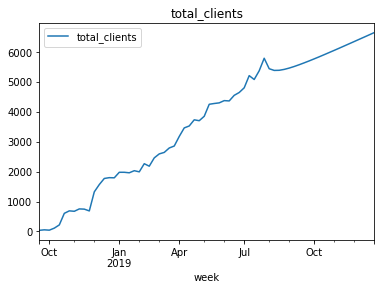

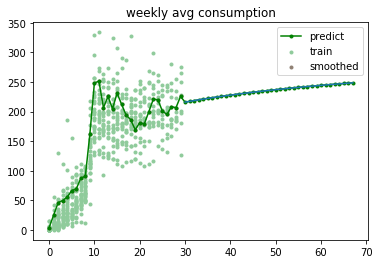

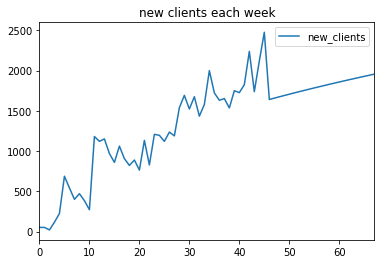

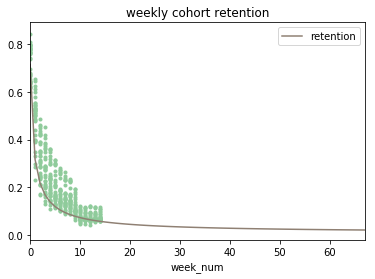

,paid,consumption_estimate
month,,
Sep,4.119756e+02,NaN
Oct,2.079080e+03,NaN
Nov,4.304773e+04,NaN
Dec,2.747649e+05,NaN
Jan,3.585504e+05,NaN
Feb,6.001051e+05,NaN
Mar,6.503779e+05,NaN
Apr,1.278429e+06,NaN
May,1.174085e+06,NaN


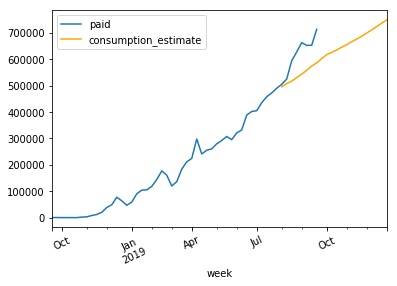

In [324]:
get_forecast('mass', shift=9)

In [325]:
#shift — сдвиг, для проверки прогноза, нужно брать столько недель, чтобы захватывало полные месяцы, 
#которые можно проверить в табличке с прогнозом  (самый точный прогноз будет при shift = 0, когда модель смотрит на 
#все доступные данные)

def get_forecast_debug(b_segment, shift=0):
    warnings.filterwarnings("ignore")
    y, m, d = 2018, 9, 17 #first paid cons in mass
    if (b_segment != 'mass'):
        y, m, d = 2018, 10, 17 #first paid cons in medium
        
    weeks = []
    finish_date = date(2020, 1, 1) #задаем конец прогноза
    date_obj = date(y, m, d)
    date_obj += timedelta(days=(7-date_obj.weekday()) % 7) #to week start   
    start_date = str(date_obj)
    while date_obj < finish_date:
        weeks.append(str(date_obj))
        date_obj += timedelta(days=7)
    week_num = len(weeks)
    
    
    curr_week = datetime.now()
    curr_week += timedelta(days=(7-curr_week.weekday()) % 7)  
    weeks_since_cons_start = (curr_week - datetime(y, m, d, 0, 0, 0)).days // 7  
    weeks_left = weeks[weeks_since_cons_start - shift:]

    ret_q, clients_q, avg_q, real_cons_q = make_query(b_segment, start_date) 
    real_avg_q, real_ret_q, real_clients_q = make_real_query(b_segment, start_date)

    ret = make_df(ret_q, ['week', 'retentions'], 'retentions')
    ret_popt, _ = curve_fit(f_ret, list(range(len(ret.index))), list(ret['smoothed'].values))
    clients = chyt_execute_query(query=clients_q, cluster=cluster, alias=alias, token=token, columns=
                              ['clients', 'ba_created'])
    clients = clients.astype({"clients" : int, "ba_created" : 'datetime64[h]'}) 
    clients_popt, _ = curve_fit(f_clients, list(range(len(clients.index))), list(clients['clients'].values))
    
    weekly_avg = make_df(avg_q, ['week', 'weekly_avg'], 'weekly_avg')
    weekly_avg = weekly_avg.astype({'week' : int})
    weekly_avg['sqr'] = weekly_avg['week']**2
    weekly_avg['sqrt'] = weekly_avg['week'] ** 0.5
    weekly_avg['small'] = weekly_avg['week'] ** 0.25
    weekly_avg['smaller'] = weekly_avg['week'] ** 0.1
    
    real_weekly_cons = chyt_execute_query(query=real_cons_q, cluster=cluster, alias=alias, token=token, columns=
                              ['paid', 'week'])
    real_weekly_cons = real_weekly_cons.astype({'paid' : float, 'week' : 'datetime64[h]'})    
    real_avg_cons_df = chyt_execute_query(query=real_avg_q, cluster=cluster, alias=alias, token=token, columns=
                              ['cohort_week', 'week', 'weekly_avg'])
    real_avg_cons_df = real_avg_cons_df.astype({'weekly_avg' : float, 'week' : int,
                                                'cohort_week' : 'datetime64[h]'}) 
    real_ret_df = chyt_execute_query(query=real_ret_q, cluster=cluster, alias=alias, token=token, columns=
                              ['cohort_week', 'week', 'ret'])
    real_ret_df = real_ret_df.astype({'ret' : float, 'week' : int,
                                                'cohort_week' : 'datetime64[h]'}) 
    

    a_ret, b_ret, c_ret, d_ret = ret_popt
    a_exp, b_exp, c_exp, d_exp = clients_popt
    avg_len = len(weekly_avg.index)
    clients_len = len(clients.index)
    
    weeks_df = pd.DataFrame()
    weeks_df['week'] = range(week_num)
    weeks_df['sqr'] =  weeks_df['week']**2
    weeks_df['big'] =  weeks_df['week']**0.75
    weeks_df['sqrt'] =  weeks_df['week']**0.5
    weeks_df['small'] =  weeks_df['week']**0.25
    weeks_df['smaller'] =  weeks_df['week']**0.1
    
    model = Ridge() #линейная регресиия
    feature_list = ['week', 'small', 'smaller', 'sqrt']
    model.fit(weekly_avg[feature_list].iloc[7: ], weekly_avg[['smoothed']].iloc[7: ]) #8 недель 
                                                                                    #это примерно триальный период
    y_pred = model.predict(weeks_df[feature_list].iloc[avg_len : ])
    
    avg_forecast = list(weekly_avg['smoothed']) + list(y_pred.flatten())
    
    
    retention_df = pd.DataFrame({'week_num' : list(range(week_num)), 
                                 'retention' : [f_ret(x, a_ret, b_ret, c_ret, d_ret) for x in range(week_num)]})
    avg_cons_df = pd.DataFrame({'week_num' : list(range(week_num)), 
                                'avg_cons' :  avg_forecast})
    
    
    
    new_clients_num = [f_clients(x, a_exp, b_exp, c_exp, d_exp) for x in range(clients_len - shift, week_num)]
    new_clients_num = list(clients['clients'][: clients_len - shift]) + new_clients_num
    
    new_clients_df = pd.DataFrame({'week' : weeks, 'new_clients' :  new_clients_num})
    cons_est = [get_total_cons(i, new_clients_df, retention_df, avg_cons_df) for i in range(weeks_since_cons_start -
                                                                                          shift, week_num)]
    weekly_cons_df = pd.DataFrame({'week' : weeks_left, 
                                  'consumption_estimate' : cons_est})    
    weekly_cons_df= weekly_cons_df.astype({"consumption_estimate" : float, "week" : 'datetime64[h]'}) 
    weekly_cons_df['month'] = weekly_cons_df['week'].apply(get_month)
    weekly_cons_df['month_id'] = weekly_cons_df['week'].apply(lambda x: (x.year, x.month))
   
    real_cons_est = [get_total_real_cons(i, new_clients_df, real_ret_df, real_avg_cons_df, weeks[:29])
                     for i in range(29)]
    real_weekly_cons_df = pd.DataFrame({'week' : weeks[: 29], 
                                  'real_consumption_estimate' : real_cons_est})    
    real_weekly_cons_df= real_weekly_cons_df.astype({"real_consumption_estimate" : float, "week" : 'datetime64[h]'}) 
    
    month_cons_df =  weekly_cons_df[['consumption_estimate', 'month', 'month_id']].\
                                                        groupby(['month', 'month_id']).sum()
    month_cons_df.sort_values(by='month_id', inplace=True)
    month_cons_df.reset_index(level=1, inplace=True)
    
    real_weekly_cons['month'] = real_weekly_cons['week'].apply(get_month)
    real_weekly_cons['month_id'] = real_weekly_cons['week'].apply(lambda x: (x.year, x.month))
    real_month_cons_df = real_weekly_cons[['paid', 'month', 'month_id']].groupby(['month', 'month_id']).sum()
    real_month_cons_df.sort_values(by='month_id', inplace=True)
    real_month_cons_df.reset_index(level=1, inplace=True)
    real_month_cons_df = real_month_cons_df.merge(month_cons_df, on=['month_id', 'month'], how='outer')
    
    month_cons_df.drop(columns=['month_id'], inplace=True)
    real_month_cons_df.drop(columns=['month_id'], inplace=True)
    

    total_clients = [get_total_clients(i, new_clients_df, retention_df) for i in range(len(weeks))]
    total_clients_df = pd.DataFrame({'week' : weeks, 'total_clients' : total_clients})  
    total_clients_df = total_clients_df.astype({'week' : 'datetime64', 'total_clients': int})
    ax = total_clients_df.plot(x='week', y='total_clients', title='total_clients')
    

    real_clients =  chyt_execute_query(query=real_clients_q, cluster=cluster, alias=alias, token=token, columns=
                              ['clients', 'week'])
    real_clients = real_clients.astype({'week' : 'datetime64', 'clients': int})
    real_clients.plot(x='week', y='clients', ax=ax)
    
    real_total_clients = [get_total_real_clients(i, clients, real_ret_df, real_avg_cons_df, weeks[:29]) 
                          for i in range(29)]
    real_total_clients_df = pd.DataFrame({'week' : weeks[: 29], 'real_total_clients' : real_total_clients})  
    real_total_clients_df = real_total_clients_df.astype({'week' : 'datetime64', 'real_total_clients': int})
    real_total_clients_df.plot(x='week', y='real_total_clients', title='real_total_clients', color='green', ax=ax)
    plt.show()
    #ploting
    x = []
    y = []
    x_retention = []
    retention = []
    
    for i in range(len(weekly_avg.index)):
        for j in range(len(weekly_avg['weekly_avg'][i])):
            x.append(i)
            y.append(weekly_avg['weekly_avg'][i][j])
            
    plt.scatter(x, y, color='#8FCB9B', marker='.', label='train')
    plt.scatter(range(len(weekly_avg.index)), weekly_avg['smoothed'], color='#8F8073', marker='.', label='smoothed')  
    plt.plot(list(range(len(avg_forecast))), avg_forecast , color='green', label='predict_smoothed', marker='.')
    plt.legend()
    new_clients_df.plot(title='new clients each week')
    plt.show()

    
    for i in range(len(ret.index)):
        for j in range(len(ret['retentions'][i])):
            x_retention.append(i)
            retention.append(ret['retentions'][i][j])

    fig, ax = plt.subplots(1, 1)
    x_ret = np.linspace(0, week_num, 1000)
    ax.scatter(x=x_retention, y=retention, color='#8FCB9B', marker='.')
    ax.set_title('retention')
    retention_df.plot(x='week_num', y='retention', title='weekly cohort retention', color='#8F8073', ax=ax)
    plt.show()
    
    avg_cons_df.plot(x='week_num', y='avg_cons', title='weekly cohort avg consumption')
    plt.show()
    
    ax = real_weekly_cons.plot('week', 'paid')
    weekly_cons_df.plot('week', 'consumption_estimate', color='orange', ax=ax)
    real_weekly_cons_df.plot('week', 'real_consumption_estimate', color='green', ax=ax)
    plt.xticks(rotation=25)
    display(real_month_cons_df) #resulting df

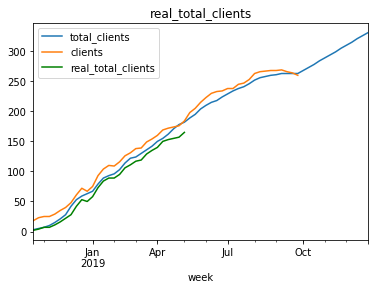

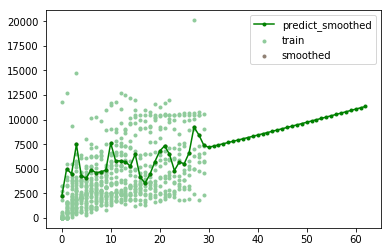

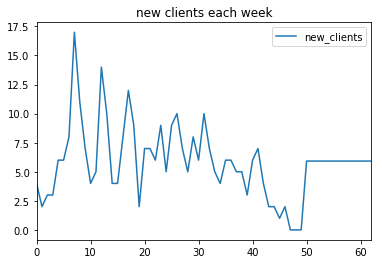

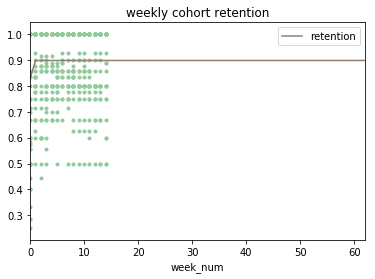

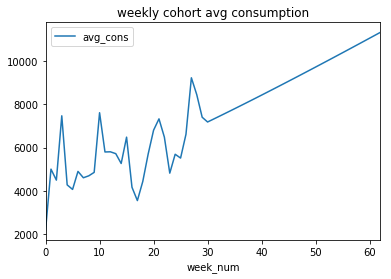

,paid,consumption_estimate
month,,
Oct,1.895972e+04,NaN
Nov,1.118587e+05,NaN
Dec,5.692306e+05,NaN
Jan,1.077163e+06,NaN
Feb,1.480443e+06,NaN
Mar,1.847618e+06,NaN
Apr,2.841560e+06,NaN
May,2.578924e+06,NaN
Jun,3.257675e+06,NaN


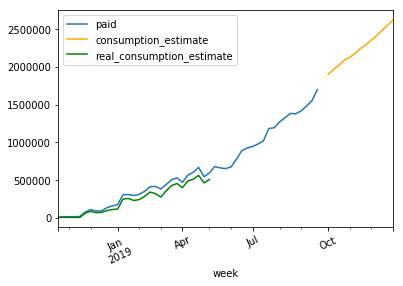

In [326]:
get_forecast_debug('medium')